In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

class HousePricePredictor:
    def __init__(self):
        self.model = LinearRegression()
        self.imputer = SimpleImputer(strategy="mean")
        self.features = None  # Список признаков, используемых при обучении
    
    def fit(self, train_path):
        # Загрузка обучающих данных
        data = pd.read_csv(train_path)

        # Оставляем только числовые признаки
        numeric_data = data.select_dtypes(include=[np.number])

        # Разделяем на признаки и целевую переменную
        X = numeric_data.drop(columns=["SalePrice"])
        y = numeric_data["SalePrice"]

        # Запоминаем порядок признаков
        self.features = X.columns  

        # Заполняем пропущенные значения средними
        X = pd.DataFrame(self.imputer.fit_transform(X), columns=self.features)

        # Кросс-валидация на 5 фолдов
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(self.model, X, y, cv=kf, scoring='neg_mean_absolute_error')

        # Обучаем модель на всех данных
        self.model.fit(X, y)

        print(f"Cross-validation MAE: {-np.mean(scores):.2f} ± {np.std(scores):.2f}")

    def predict(self, test_path, output_path):
        # Загрузка тестовых данных
        test_data = pd.read_csv(test_path)

        # Сохраняем ID
        test_ids = test_data["Id"]

        # Оставляем только числовые признаки
        numeric_test = test_data.select_dtypes(include=[np.number])

        # Проверяем, есть ли все нужные признаки
        missing_cols = set(self.features) - set(numeric_test.columns)
        for col in missing_cols:
            numeric_test[col] = 0  # Добавляем недостающие признаки с нулями

        # Заполняем пропущенные значения средними
        X_test = pd.DataFrame(self.imputer.transform(numeric_test[self.features]), columns=self.features)

        # Делаем предсказания
        predictions = self.model.predict(X_test)

        # Сохраняем предсказания в CSV
        result = pd.DataFrame({"Id": test_ids, "SalePrice": predictions})
        result.to_csv(output_path, index=False)
        print(f"Predictions saved to {output_path}")

# Использование:
predictor = HousePricePredictor()
predictor.fit("train_hw.csv")
predictor.predict("test_hw.csv", "predictions_cross.csv")


Cross-validation MAE: 23529.18 ± 1758.99
Predictions saved to predictions.csv


In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

# Загружаем данные
train_data = pd.read_csv("train_hw.csv")

# Оставляем только числовые признаки
numeric_data = train_data.select_dtypes(include=[np.number])
X = numeric_data.drop(columns=["SalePrice", "Id"])
y = numeric_data["SalePrice"]

# Определяем pipeline
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Заполняем пропуски средним значением
    ('scaler', StandardScaler()),  # Масштабируем данные
    ('model', ElasticNet())  # Модель ElasticNet
])

# Гиперпараметры для подбора
param_grid = {
    'model__alpha': [110],
    'model__l1_ratio': [ 1]
}

# Подбор гиперпараметров с GridSearchCV
search = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=10)
search.fit(X, y)

# Обучаем лучшую модель на всех данных
best_model = search.best_estimator_
best_model.fit(X, y)

# Получаем предсказания на обучающих данных
y_pred = best_model.predict(X)

# Вычисляем модуль средней ошибки (MAE)
mae = mean_absolute_error(y, y_pred)

# Вычисляем R² (коэффициент детерминации)
r2 = r2_score(y, y_pred)

# Выводим результаты
print(f"Модуль средней ошибки (MAE): {mae}")
print(f"R²: {r2}")

def predict(test_file, output_file):
    # Загружаем тестовые данные
    test_data = pd.read_csv(test_file)
    
    # Оставляем только числовые признаки
    test_numeric = test_data.select_dtypes(include=[np.number])
    
    # Убедимся, что тестовые данные содержат те же признаки, что и обучающие
    test_numeric = test_numeric.reindex(columns=X.columns, fill_value=np.nan)
    
    # Прогнозируем на тестовых данных
    predictions = best_model.predict(test_numeric)
    
    # Создаем DataFrame с результатами
    result = pd.DataFrame({
        "Id": test_data["Id"],
        "SalePrice": predictions
    })
    
    # Сохраняем результаты в CSV
    result.to_csv(output_file, index=False)
    print(f"Предсказания сохранены в {output_file}")

# Прогнозирование на тестовых данных
predict("test_hw.csv", "predictions_elastic_net.csv")


Модуль средней ошибки (MAE): 21652.069847633327
R²: 0.80293520408333
Предсказания сохранены в predictions_elastic_net.csv


In [32]:
search.best_params_

{'model__alpha': 100, 'model__l1_ratio': 1}

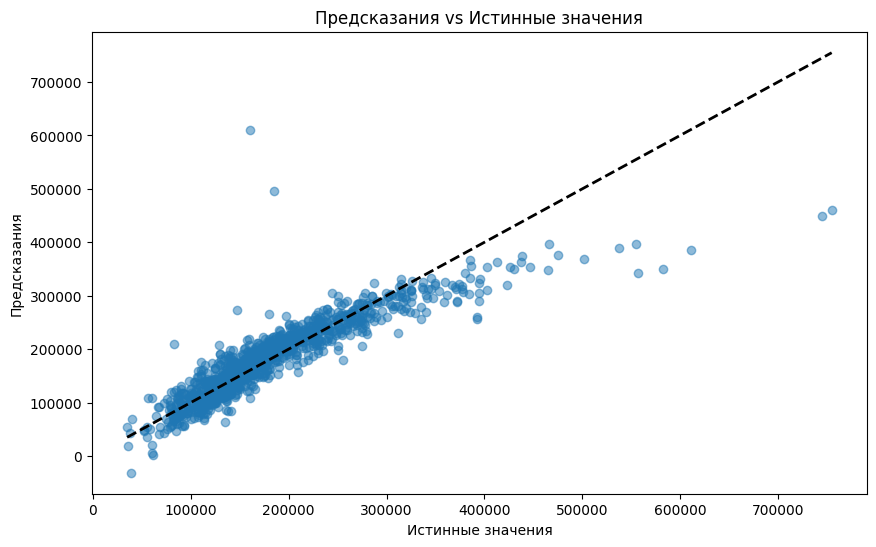

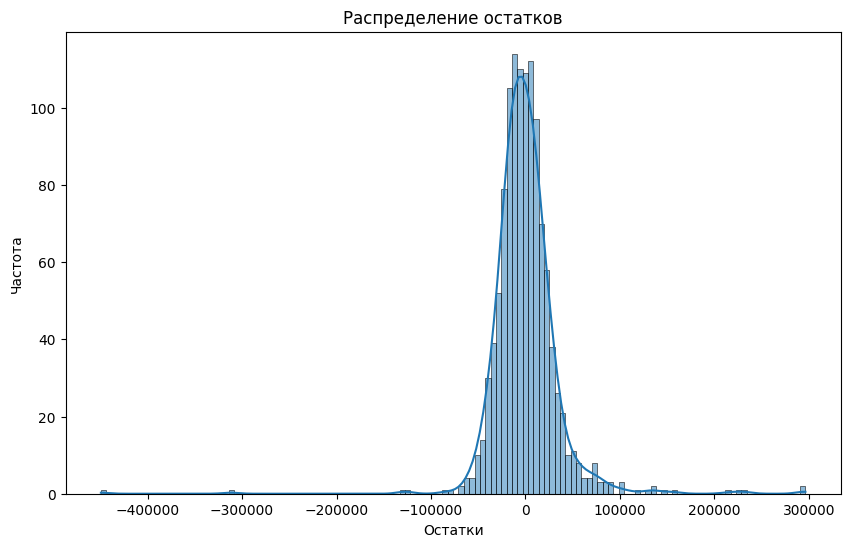

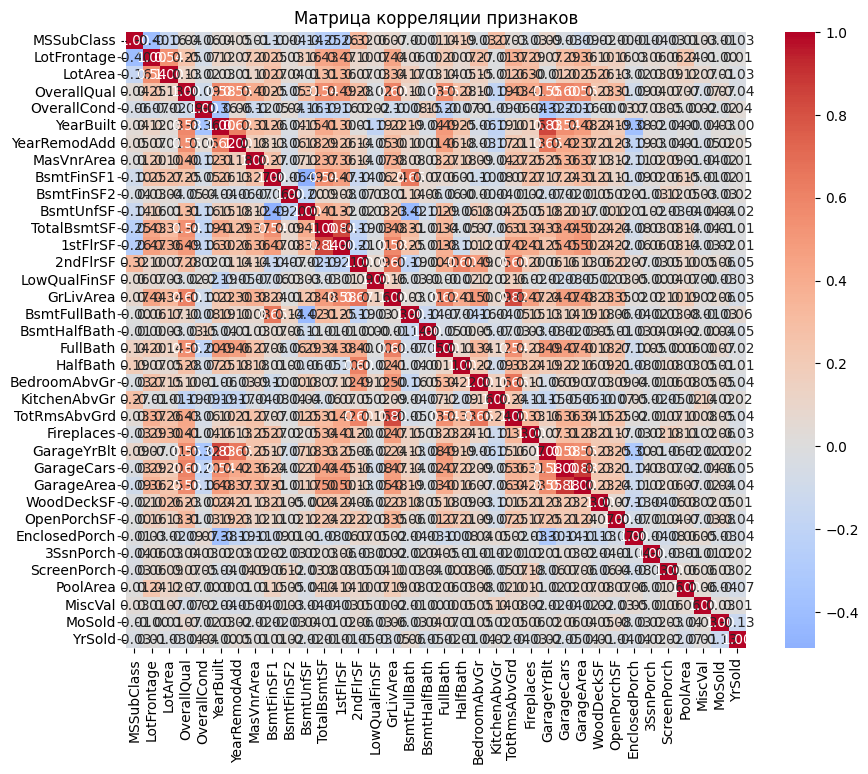

Средняя квадратичная ошибка (MSE): 1287127675.0509217
R^2: 0.7987655651351726


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# Получаем предсказания
y_pred = best_model.predict(X)

# График зависимости предсказанных значений от истинных
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([min(y), max(y)], [min(y), max(y)], 'k--', lw=2)  # Линия идеальных предсказаний
plt.title('Предсказания vs Истинные значения')
plt.xlabel('Истинные значения')
plt.ylabel('Предсказания')
plt.show()

# График остатков
residuals = y - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Распределение остатков')
plt.xlabel('Остатки')
plt.ylabel('Частота')
plt.show()

# Heatmap корреляции
corr_matrix = X.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Матрица корреляции признаков')
plt.show()

# Оценка модели: MSE и R^2
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
print(f"Средняя квадратичная ошибка (MSE): {mse}")
print(f"R^2: {r2}")


In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Загружаем обучающие данные
train_data = pd.read_csv("train_hw.csv")

# Создаем X и y, используя все признаки, кроме SalePrice и Id
X = train_data.drop(columns=["SalePrice", "Id"])
y = train_data["SalePrice"]

# Определяем списки признаков
numeric_features = X.select_dtypes(include=[np.number]).columns
categorical_features = X.select_dtypes(exclude=[np.number]).columns

# Определяем трансформер для числовых признаков
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Определяем трансформер для категориальных признаков
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Объединяем числовые и категориальные признаки
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Полный pipeline, включающий предобработку и модель
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', ElasticNet(max_iter=10000))
])

# Определяем гиперпараметры для подбора
param_grid = {
    'model__alpha': [115, 120, 125],
    'model__l1_ratio': [0.99, 1]
}

# Подбираем лучшие параметры с помощью GridSearchCV (оценка по neg MAE)
search = GridSearchCV(pipeline, param_grid, scoring='neg_mean_absolute_error', cv=5)
search.fit(X, y)

# Получаем лучшую модель
best_model = search.best_estimator_

# Вычисляем MAE и R^2 на обучающих данных
y_pred = best_model.predict(X)
mae = mean_absolute_error(y, y_pred)
r2 = best_model.score(X, y)
print(f"Средний модуль ошибки (MAE): {mae}")
print(f"R^2: {r2}")

# Функция для предсказаний на тестовых данных
def predict(test_file, output_file):
    test_data = pd.read_csv(test_file)
    # Создаем X для теста аналогично обучающим данным
    test_X = test_data.drop(columns=["Id"])
    
    predictions = best_model.predict(test_X)
    
    result = pd.DataFrame({
        "Id": test_data["Id"],
        "SalePrice": predictions
    })
    
    result.to_csv(output_file, index=False)
    print(f"Предсказания сохранены в {output_file}")
    print(search.best_params_)

predict("test_hw.csv", "predictions_elastic_net_with_cat.csv")


Средний модуль ошибки (MAE): 14721.768591271873
R^2: 0.9124618456843631
Предсказания сохранены в predictions_elastic_net_with_cat.csv
{'model__alpha': 115, 'model__l1_ratio': 1}


In [33]:
search.best_estimator_

Pipeline(steps=[('dropper',
                 FunctionTransformer(func=<function drop_features at 0x000002F3DE61E660>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1...
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('model', ElasticNet(alpha=110, l1_ratio=1, max_iter=10000))])

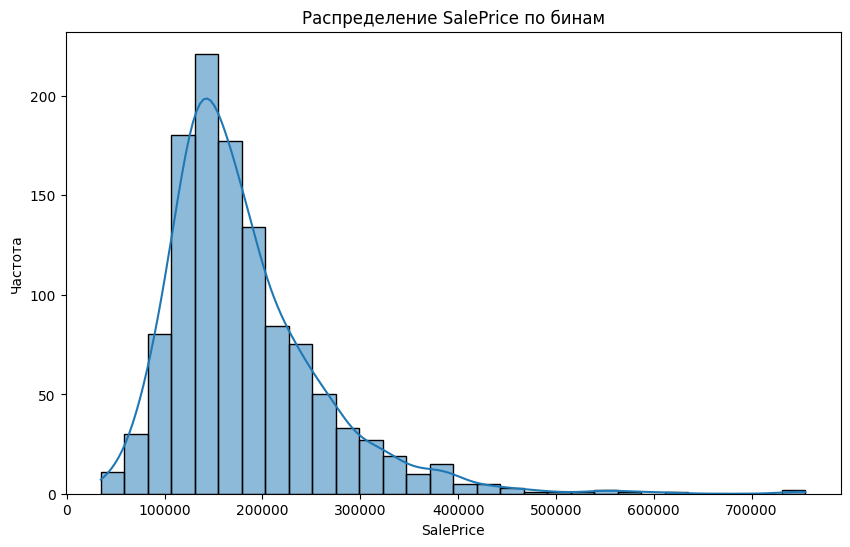

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Загружаем данные
train_data = pd.read_csv("train_hw.csv")

# Создаём гистограмму с распределением SalePrice
plt.figure(figsize=(10, 6))
sns.histplot(train_data['SalePrice'], bins=30, kde=True)  # kde=True для наложения кривой плотности
plt.title('Распределение SalePrice по бинам')
plt.xlabel('SalePrice')
plt.ylabel('Частота')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Загружаем данные
train_data = pd.read_csv("train_hw.csv")

# Определяем 90-й процентиль для SalePrice
percentile_90 = np.percentile(train_data['SalePrice'], 100)

# Отфильтровываем данные, оставляем только те, где SalePrice <= 90-й процентиль
filtered_data = train_data[train_data['SalePrice'] <= percentile_90]

# Формируем X как все признаки, кроме SalePrice и Id, из фильтрованных данных
X = filtered_data.drop(columns=["SalePrice", "Id"])
y = filtered_data["SalePrice"]

# Определяем числовые и категориальные признаки на основе X
numeric_features = X.select_dtypes(include=[np.number]).columns
categorical_features = X.select_dtypes(exclude=[np.number]).columns

# Определяем pipeline для числовых признаков
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Определяем pipeline для категориальных признаков
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Объединяем числовые и категориальные признаки в ColumnTransformer,
# используя имена признаков из X, чтобы они точно совпадали.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Полный pipeline с ElasticNet (жёсткая Lasso регуляризация: alpha=100, l1_ratio=1)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', ElasticNet(alpha=100, l1_ratio=1, max_iter=5000))
])

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучаем модель
pipeline.fit(X_train, y_train)

# Получаем предсказания и оцениваем модель
y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Средний модуль ошибки (MAE): {mae}")

# Функция для предсказания на тестовых данных и сохранения результатов
def predict(test_file, output_file):
    test_data = pd.read_csv(test_file)
    # Предполагается, что тестовый набор имеет ту же структуру, что и обучающий (без SalePrice)
    X_test_data = test_data.drop(columns=["Id"])
    predictions = pipeline.predict(X_test_data)
    result = pd.DataFrame({
        "Id": test_data["Id"],
        "SalePrice": predictions
    })
    result.to_csv(output_file, index=False)
    print(f"Предсказания сохранены в {output_file}")

# Пример использования функции для тестовых данных
predict("test_hw.csv", "predictions_elastic_net_with_cat_perc.csv")


InvalidParameterError: The 'alpha' parameter of ElasticNet must be a float in the range [0.0, inf). Got [100, 110, 120, 130, 150] instead.

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer

# Функция для ограничения выбросов по IQR
def clip_outliers_iqr(df, columns):
    df = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df

# Загружаем данные
train_data = pd.read_csv("train_hw.csv")

# Создаем X и y, используя все признаки, кроме SalePrice и Id
X = train_data.drop(columns=["SalePrice", "Id"])
y = train_data["SalePrice"]

# Определяем списки признаков
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

# 🔹 Обработчик выбросов с использованием IQR
numeric_transformer = Pipeline(steps=[
    ('clipper', FunctionTransformer(lambda df: clip_outliers_iqr(df, df.columns), validate=False)),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Трансформер для категориальных признаков
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Объединяем числовые и категориальные признаки
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Полный pipeline с Lasso (L1-регуляризация)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Lasso(max_iter=10000))
])

# Определяем гиперпараметры для Lasso
param_grid = {
    'model__alpha': [125, 150]
}

# Подбор параметров через GridSearchCV (по отрицательному MAE)
search = GridSearchCV(pipeline, param_grid, scoring='neg_mean_absolute_error', cv=5)
search.fit(X, y)

# Получаем лучшую модель
best_model = search.best_estimator_

# Вычисляем MAE и R^2 на обучающем наборе
y_pred = best_model.predict(X)
mae = mean_absolute_error(y, y_pred)
r2 = best_model.score(X, y)
print(f"Средний модуль ошибки (MAE): {mae}")
print(f"R^2: {r2}")

# Функция для предсказаний на тестовых данных
def predict(test_file, output_file):
    test_data = pd.read_csv(test_file)
    test_X = test_data.drop(columns=["Id"])
    predictions = best_model.predict(test_X)
    result = pd.DataFrame({
        "Id": test_data["Id"],
        "SalePrice": predictions
    })
    result.to_csv(output_file, index=False)
    print(f"Предсказания сохранены в {output_file}")

# Запускаем предсказания
predict("test_hw.csv", "predictions_lasso_iqr.csv")


Средний модуль ошибки (MAE): 14801.174687968745
R^2: 0.9056545037944291
Предсказания сохранены в predictions_lasso_iqr.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer

# Определим функции для кодирования

def encode_ordered(df):
    """Преобразует упорядоченные категориальные признаки в числовые по заданным правилам."""
    df = df.copy()
    mapping = {
        "ExterQual": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "ExterCond": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "BsmtQual": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "BsmtCond": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "BsmtExposure": {"NA": 0, "No": 1, "Mn": 2, "Av": 3, "Gd": 4},
        "KitchenQual": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "HeatingQC": {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "FireplaceQu": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "GarageQual": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5},
        "GarageCond": {"NA": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
    }
    for col, map_dict in mapping.items():
        if col in df.columns:
            df[col] = df[col].replace(map_dict)
    return df

def encode_simple(df):
    """Простое кодирование: CentralAir (N->0, Y->1) и GarageFinish."""
    df = df.copy()
    if "CentralAir" in df.columns:
        df["CentralAir"] = df["CentralAir"].replace({'N': 0, 'Y': 1})
    if "GarageFinish" in df.columns:
        df["GarageFinish"] = df["GarageFinish"].replace({"NA": 0, "Unf": 1, "RFn": 2, "Fin": 3})
    return df

# Загружаем обучающие данные
train_data = pd.read_csv("train_hw.csv")

# Создаем X и y, используя все признаки, кроме SalePrice и Id
X = train_data.drop(columns=["SalePrice", "Id"])
y = train_data["SalePrice"]

# Определяем списки признаков
# Предполагаем, что признаки в train_data имеют следующие имена:
ordered_cols = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", 
                "BsmtExposure", "KitchenQual", "HeatingQC", "FireplaceQu", 
                "GarageQual", "GarageCond"]
simple_cols = ["CentralAir", "GarageFinish"]
# Остальные категориальные признаки (из всех, что не числовые)
all_cat = X.select_dtypes(exclude=[np.number]).columns.tolist()
group2_cols = [col for col in all_cat if col not in ordered_cols and col not in simple_cols]

# Числовые признаки
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()

# Определяем трансформеры для каждой группы
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

ordered_transformer = Pipeline(steps=[
    ('encoder', FunctionTransformer(encode_ordered, validate=False)),
    ('imputer', SimpleImputer(strategy='mean')),  # После кодирования, NaN заполнить средним
    ('scaler', StandardScaler())
])

simple_transformer = Pipeline(steps=[
    ('encoder', FunctionTransformer(encode_simple, validate=False))
    # Можно добавить импьютацию, если нужно
])

group2_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Собираем ColumnTransformer: для числовых и категориальных признаков отдельно.
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_cols),
    ('ord', ordered_transformer, ordered_cols),
    ('simp', simple_transformer, simple_cols),
    ('cat', group2_transformer, group2_cols)
], remainder='passthrough')  # Если есть признаки, которые не попали в группы, пропускаем их

# Полный pipeline с Lasso (чистая L1-регуляризация)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Lasso(max_iter=10000))
])

# Определяем гиперпараметры для Lasso (подбираем alpha)
param_grid = {
    'model__alpha': [115, 120, 125]
}

# Подбираем лучшие параметры с помощью GridSearchCV (оцениваем по отрицательному MAE, cv=5)
search = GridSearchCV(pipeline, param_grid, scoring='neg_mean_absolute_error', cv=5)
search.fit(X, y)

# Получаем лучшую модель
best_model = search.best_estimator_

# Вычисляем MAE и R^2 на обучающих данных
y_pred = best_model.predict(X)
mae = mean_absolute_error(y, y_pred)
r2 = best_model.score(X, y)
print(f"Средний модуль ошибки (MAE): {mae}")
print(f"R^2: {r2}")

# Функция для предсказаний на тестовых данных
def predict(test_file, output_file):
    test_data = pd.read_csv(test_file)
    test_X = test_data.drop(columns=["Id"])
    predictions = best_model.predict(test_X)
    result = pd.DataFrame({
        "Id": test_data["Id"],
        "SalePrice": predictions
    })
    result.to_csv(output_file, index=False)
    print(f"Предсказания сохранены в {output_file}")

predict("test_hw.csv", "predictions_worst.csv")


C:\Users\Dima\AppData\Local\Temp\ipykernel_5028\828935552.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].replace(map_dict)
C:\Users\Dima\AppData\Local\Temp\ipykernel_5028\828935552.py:37: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["CentralAir"] = df["CentralAir"].replace({'N': 0, 'Y': 1})
C:\Users\Dima\AppData\Local\Temp\ipykernel_5028\828935552.py:39: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `re

ValueError: 
All the 15 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Dima\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Dima\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dima\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\Dima\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dima\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py", line 982, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "c:\Users\Dima\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Dima\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 1370, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "c:\Users\Dima\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 1107, in check_array
    _assert_all_finite(
  File "c:\Users\Dima\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 120, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "c:\Users\Dima\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py", line 169, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
Lasso does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
